In [221]:
import copy
import json
import os
import pathlib
import sys
import pickle
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

# shap displays NumbaDeprecationWarning when importing -- supress them
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

import shap
import torch
from torch import Tensor, sigmoid

# logging.basicConfig(level=logging.INFO)

# correct path to repository root
REPOSITORY_ROOT = os.path.join(os.getcwd(), "..", "..", "..")
sys.path.append(REPOSITORY_ROOT)

from nebula import PEDynamicFeatureExtractor
from nebula.models.attention import TransformerEncoderOptionalEmbedding
from nebula.preprocessing import JSONTokenizerNaive

from nebula.misc.plots import set_size

from nebula.misc import fix_random_seed
fix_random_seed(0)


def compute_score(llm, x, verbose=True):
    logit = llm(x)
    prob = sigmoid(logit)
    if verbose:
        print(f"\n[!!!] Probability of being malicious: {prob.item():.3f} | Logit: {logit.item():.3f}")
    return prob.item()


def load_tokenizer():
    with open(os.path.join(REPOSITORY_ROOT, "nebula", "objects",
                           "speakeasy_whitespace_50000_vocab.json")) as f:
        vocab = json.load(f)

    tokenizer = JSONTokenizerNaive(
        vocab_size=len(vocab),
        seq_len=512,
        vocab=vocab
    )
    return tokenizer

def tokenize_sample(report_path, encode=True):
    extractor = PEDynamicFeatureExtractor()
    filtered_report = extractor.filter_and_normalize_report(report_path)
    tokenizer = load_tokenizer()
    tokenized_report = tokenizer.tokenize(filtered_report)
    if encode:
        encoded_report = tokenizer.encode(tokenized_report, pad=True, tokenize=False)
        x = Tensor(encoded_report).long()
        return x
    else:
        return tokenized_report


def embed(llm_model, report, device="cpu"):
    src = tokenize_sample(report)
    s = llm_model.split(src)
    s = s.to(device)
    e = llm_model.embed(s)
    return e


def plot_shap_values(shap_values: np.ndarray, name: str):
    shap_values = shap_values.mean(axis=2)
    pos_idx = shap_values[0] >= 0
    neg_index = shap_values[0] < 0
    pos_shap = copy.deepcopy(shap_values)[0]
    pos_shap[neg_index] = 0
    neg_shap = copy.deepcopy(shap_values)[0]
    neg_shap[pos_idx] = 0
    x = range(512)
    plt.bar(x, pos_shap)
    plt.bar(x, neg_shap)
    plt.title(name)
    plt.show()


def load_model(skip_embedding=False):
    pretrained_model = os.path.join(REPOSITORY_ROOT, "nebula", "objects", "speakeasy_whitespace_50000_torch.model")
    with open(os.path.join(REPOSITORY_ROOT, "nebula", "objects", "speakeasy_whitespace_50000_vocab.json")) as f:
        vocab = json.load(f)
    model_config = {
        "vocab_size": len(vocab),
        "maxlen": 512,
        "chunk_size": 64,  # input splitting to chunks
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1,  # binary classification
        "hiddenNeurons": [64],  # classifier ffnn dims
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True,
        "skip_embedding": skip_embedding
    }
    state_dict = torch.load(pretrained_model, map_location='cpu')
    llm = TransformerEncoderOptionalEmbedding(**model_config)
    llm.load_state_dict(state_dict)
    llm.eval()
    return llm

model = load_model()
model_no_embed = load_model(skip_embedding=True)
tokenizer = load_tokenizer()

malware_folder = pathlib.Path(os.path.join(REPOSITORY_ROOT, "evaluation", "explanation", "malware"))
goodware_folder = pathlib.Path(os.path.join(REPOSITORY_ROOT, "evaluation", "explanation", "goodware"))

baseline_report = os.path.join(REPOSITORY_ROOT, r"emulation", "report_baseline.json")

x_baseline = tokenize_sample(baseline_report)
x_embed_baseline = embed(model, baseline_report)

In [222]:
def generalize_shap_values(reports, model, embed_baseline, threshold=0.5, verbose=True):
    explanations_tp = {}
    explanations_fn = {}
    if isinstance(reports, pathlib.Path):
        generator = reports.glob("*.json")
    if isinstance(reports, list):
        generator = [x for x in reports if x.endswith("json")]
    tp_idx = 0
    fn_idx = 0
    length = len(generator)
    for i, report in enumerate(generator):
        print(f"[*] Processing: {i}/{length} | TPs: {tp_idx} | FNs: {fn_idx}", end="\r")
        try:
            name = report.name
        except AttributeError:
            name = report
        if verbose:
            print(name)
        x_embed = embed(model, str(report))
        prob = compute_score(model, x_embed, verbose=verbose)
        explainer = shap.GradientExplainer(model_no_embed, data=embed_baseline)
        explanations = explainer.shap_values(x_embed, nsamples=50)
        token_idxs = tokenize_sample(str(report), encode=True)
        if prob > threshold:
            tp_idx += 1
            explanations_tp[name] = (explanations, token_idxs)
        else:
            fn_idx += 1
            explanations_fn[name] = (explanations, token_idxs)
    return explanations_tp, explanations_fn

def aggregate_values(data, vocab):
    # Initialize an output dictionary with vocab keys and values set to zero
    output_dict = {k: 0 for k in vocab.keys()}
    
    # Iterate through each name in data
    for values, token_idxs in tqdm(data.values()):
        # Average the shap values across the embedding dimension
        values = values.mean(axis=2).squeeze().tolist()
        token_idxs = token_idxs.squeeze().tolist()
        for v, idx in zip(values, token_idxs):
            # For each token index, find the corresponding token in vocab
            token = [k for k, i in vocab.items() if i == idx][0]
            # Add the value to the output_dict for that token
            output_dict[token] += v

    return output_dict


## Running on 1000 Trojans

In [223]:
LIMIT = 1000

trojan_folder = os.path.join(REPOSITORY_ROOT, r"data\windows_emulation_testset\report_trojan")
# 1000 files takes ~35 mins
files_limited = [os.path.join(trojan_folder, x) for x in os.listdir(trojan_folder)][:LIMIT]

explanations_tp_trojans_file = f"explanations_tp_trojans_lim_{LIMIT}.pickle"
explanations_fn_trojans_file = f"explanations_fn_trojans_lim_{LIMIT}.pickle"

if os.path.exists(explanations_tp_trojans_file) and os.path.exists(explanations_fn_trojans_file):
    with open(explanations_tp_trojans_file, "rb") as f:
        explanations_tp_trojans = pickle.load(f)
    with open(explanations_fn_trojans_file, "rb") as f:
        explanations_fn_trojans = pickle.load(f)
else:
    explanations_tp_trojans, explanations_fn_trojans = generalize_shap_values(
        files_limited,
        model_no_embed,
        x_embed_baseline,
        verbose=False
    )
    # dump as pickle
    with open(explanations_tp_trojans_file, "wb") as f:
        pickle.dump(explanations_tp_trojans, f)
    with open(explanations_fn_trojans_file, "wb") as f:
        pickle.dump(explanations_fn_trojans, f)


### True Positive Analysis

In [ ]:
agg_shap_tokens_tp = aggregate_values(explanations_tp_trojans, tokenizer.vocab)

TOP = 20
top_tp_features = sorted(agg_shap_tokens_tp.items(), key=lambda x: x[1], reverse=True)[:TOP]
top_tp_features

[('kernel32', 2.7145000577030167),
 ('0x26000', 1.319775906860253),
 ('0x4c46a0', 0.8579591625457592),
 ('0xcf0000', 0.5644899825376138),
 ('0xffe2', 0.3482311958086516),
 ('cb', 0.2932017905899588),
 ('0x698b8c', 0.2893134338736512),
 ('advapi32', 0.23758122276968185),
 ('0x400108', 0.20499050805694277),
 ('0xa6ee60', 0.14797877835062845),
 ('0x7f00', 0.1412859435319732),
 ('getprocaddress', 0.13847997858309788),
 ('123', 0.12302507824344303),
 ('0x78', 0.11978063113711848),
 ('heapalloc', 0.10451110408583728),
 ('readfile', 0.08743576936498343),
 ('getmodulehandlea', 0.06579403370112143),
 ('0xb545', 0.06475632004408513),
 ('0x7810', 0.05168666530663365),
 ('0x4', 0.05079991093378146)]

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


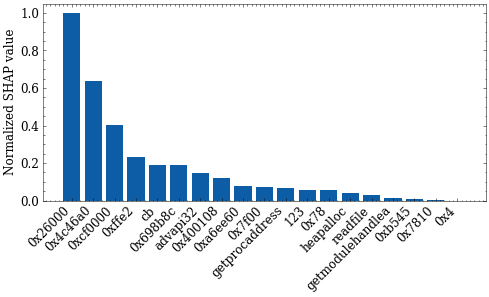

In [ ]:
plt.style.use(['science', 'no-latex'])

# [1:] to exclude kernel32
x = [x[0] for x in top_tp_features][1:]
y = np.array([x[1] for x in top_tp_features][1:])
# normalize y to be within [0, 1]
y = (y - y.min()) / (y.max() - y.min())

fig, ax = plt.subplots(figsize=set_size())
ax.bar(x, y)
ax.set_xticklabels(x, rotation=45, ha="right", fontsize=12)
ax.set_yticklabels([f"{x:.1f}" for x in ax.get_yticks()], fontsize=12)
_ = ax.set_ylabel("Normalized SHAP value", fontsize=12)
plt.tight_layout()

### False Negative Analysis

In [ ]:
agg_shap_tokens_fn = aggregate_values(explanations_fn_trojans, tokenizer.vocab)
top_fn_features = sorted(agg_shap_tokens_fn.items(), key=lambda x: x[1], reverse=False)[:TOP]
top_fn_features

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


[('<unk>', -0.04635518790434057),
 ('0x1', -0.010062842535704579),
 ('0x0', -0.006498386150708446),
 ('0x77000000', -0.004205078536833721),
 ('none', -0.001958914522640683),
 ('tlssetvalue', -0.0019085618255553407),
 ('tlsgetvalue', -0.001801541602693631),
 ('0xfa0', -0.001669068128970218),
 ('0xfeee0004', -0.0016111512408160085),
 ('0x1211fd0', -0.0013588148399044807),
 ('0x94', -0.0012081603363364379),
 ('encodepointer', -0.0010074120506738473),
 ('getcurrentthreadid', -0.0010064187399421716),
 ('0x4610', -0.0009398665910215246),
 ('dll', -0.000735781810677899),
 ('0x1000', -0.0007348851820178512),
 ('heapcreate', -0.0006668970603634829),
 ('flsgetvalue', -0.0006431560753683361),
 ('initializecriticalsectionandspincount', -0.0005358899826465506),
 ('0x46b0', -0.0003764186754973676)]

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


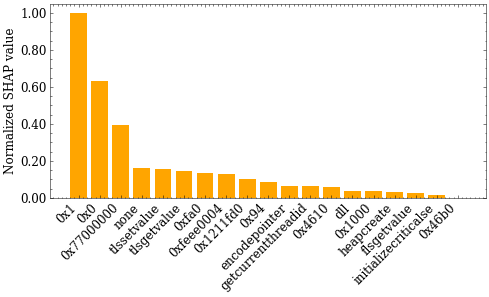

In [ ]:
plt.style.use(['science', 'no-latex'])

SKIP = 1
x = [x[0][:20] for x in top_fn_features][SKIP:]
y = np.array([x[1] for x in top_fn_features][SKIP:])
# flip sign for all y
y = -y
# normalize y to be within [0, 1]
y = (y - y.min()) / (y.max() - y.min())

fig, ax = plt.subplots(figsize=set_size())
ax.bar(x, y, color='orange')
ax.set_xticklabels(x, rotation=45, ha="right", fontsize=12)
ax.set_yticklabels([f"{x:.2f}" for x in ax.get_yticks()], fontsize=12)
_ = ax.set_ylabel("Normalized SHAP value", fontsize=12)
plt.tight_layout()

## Running on Goodware

In [ ]:
def generalize_shap_values(reports, model, embed_baseline, threshold=0.5, verbose=True):
    explanations_tp = {}
    explanations_fn = {}
    if isinstance(reports, pathlib.Path):
        generator = reports.glob("*.json")
    if isinstance(reports, list):
        generator = [x for x in reports if x.endswith("json")]
    tp_idx = 0
    fn_idx = 0
    length = len(generator)
    for i, report in enumerate(generator):
        print(f"[*] Processing: {i}/{length} | TPs: {tp_idx} | FNs: {fn_idx}", end="\r")
        try:
            name = report.name
        except AttributeError:
            name = report
        if verbose:
            print(name)
        x_embed = embed(model, str(report))
        prob = compute_score(model, x_embed, verbose=verbose)
        explainer = shap.GradientExplainer(model_no_embed, data=embed_baseline)
        explanations = explainer.shap_values(x_embed, nsamples=50)
        token_idxs = tokenize_sample(str(report), encode=True)
        if prob < threshold:
            tp_idx += 1
            explanations_tp[name] = (explanations, token_idxs)
        else:
            fn_idx += 1
            explanations_fn[name] = (explanations, token_idxs)
    return explanations_tp, explanations_fn

LIMIT = 50 # 1000

trojan_folder = os.path.join(REPOSITORY_ROOT, r"data\windows_emulation_testset\report_clean")
# 1000 files takes ~35 mins
files_limited = [os.path.join(trojan_folder, x) for x in os.listdir(trojan_folder)][:LIMIT]

explanations_tp_clean_file = f"explanations_tp_clean_lim_{LIMIT}.pickle"
explanations_fn_clean_file = f"explanations_fn_clean_lim_{LIMIT}.pickle"

if os.path.exists(explanations_tp_clean_file) and os.path.exists(explanations_fn_clean_file):
    with open(explanations_tp_clean_file, "rb") as f:
        explanations_tp_clean = pickle.load(f)
    with open(explanations_fn_clean_file, "rb") as f:
        explanations_fn_clean = pickle.load(f)
else:
    explanations_tp_clean, explanations_fn_clean = generalize_shap_values(
        files_limited,
        model_no_embed,
        x_embed_baseline,
        verbose=False
    )
    # dump as pickle
    with open(explanations_tp_clean_file, "wb") as f:
        pickle.dump(explanations_tp_clean, f)
    with open(explanations_fn_clean_file, "wb") as f:
        pickle.dump(explanations_fn_clean, f)


In [ ]:
agg_shap_tokens_tn = aggregate_values(explanations_tp_clean, tokenizer.vocab)

TOP = 20
top_tn_features = sorted(agg_shap_tokens_tn.items(), key=lambda x: x[1], reverse=True)[:TOP]
top_tn_features

100%|██████████| 33/33 [00:25<00:00,  1.32it/s]


[('kernel32', 4.511379829683621),
 ('0x7090', 0.5370337536453677),
 ('advapi32', 0.30868403752535334),
 ('heapalloc', 0.15492892601462288),
 ('1', 0.05123357141279361),
 ('0x4640', 0.03271142376732007),
 ('user32', 0.03071929839824012),
 ('0x1211f20', 0.026962915480309567),
 ('flsalloc', 0.025353193980807976),
 ('flssetvalue', 0.02392280223727805),
 ('interlockedexchange', 0.02293264858172357),
 ('0', 0.022678461640761503),
 ('0x403004', 0.019748803477793925),
 ('multibytetowidechar', 0.018421268882944195),
 ('getprocessheap', 0.016880728273052273),
 ('0xe00', 0.015315605594303554),
 ('0x76c0', 0.0130077223338531),
 ('system32', 0.01275127344559044),
 ('0x7770', 0.01107095901316914),
 ('widechartomultibyte', 0.010927548802935236)]

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


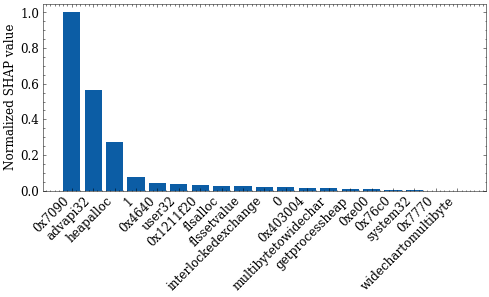

In [ ]:
plt.style.use(['science', 'no-latex'])

# [1:] to exclude kernel32
x = [x[0] for x in top_tn_features][1:]
y = np.array([x[1] for x in top_tn_features][1:])
# normalize y to be within [0, 1]
y = (y - y.min()) / (y.max() - y.min())

fig, ax = plt.subplots(figsize=set_size())
ax.bar(x, y)
ax.set_xticklabels(x, rotation=45, ha="right", fontsize=12)
ax.set_yticklabels([f"{x:.1f}" for x in ax.get_yticks()], fontsize=12)
_ = ax.set_ylabel("Normalized SHAP value", fontsize=12)
plt.tight_layout()

## Diverging Bar Plot For Both Classes

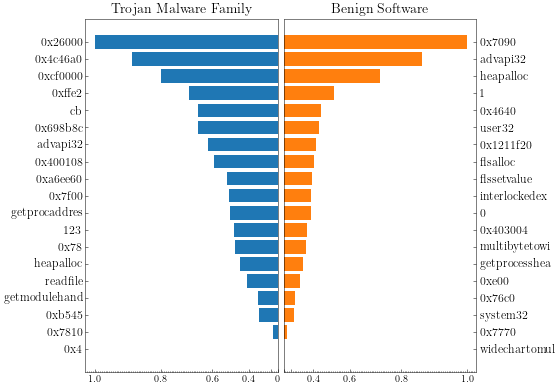

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(['science'])

def power_transform(x, alpha=0.5):
    return np.power(x, alpha)

def inverse_power_transform(y, alpha=0.5):
    return np.power(y, 1/alpha)

# Extract and normalize positive class data
FEATURE_LIM = 13 # chars
SKIP = 1
x_pos = [x[0][:FEATURE_LIM] for x in top_tp_features][SKIP:]
y_pos = np.array([x[1] for x in top_tp_features][SKIP:])
y_pos = (y_pos - y_pos.min()) / (y_pos.max() - y_pos.min())
y_pos = power_transform(y_pos)

# Extract and normalize negative class data
x_neg = [x[0][:FEATURE_LIM] for x in top_tn_features][SKIP:]
y_neg = np.array([x[1] for x in top_tn_features][SKIP:])
y_neg = (y_neg - y_neg.min()) / (y_neg.max() - y_neg.min())
y_neg = power_transform(y_neg)

# Create a figure and axis
sizes = set_size()
fig, axs = plt.subplots(1, 2, figsize=(sizes[0], sizes[1]*1.5))  # Adjust the size as needed
# fig, axs = plt.subplots(1, 2, figsize=set_size())  # Adjust the size as needed

ax = axs[0]
ax.invert_yaxis()
# Plot positive values
ax.barh(np.arange(len(x_pos)), y_pos, color='tab:blue', label='Positive', align='edge')

ax.set_yticks(np.arange(len(x_pos)) + 0.4)
ax.set_yticklabels(x_pos, fontsize=12)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
#ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_title("Trojan Malware Family", fontsize=14)

ax2 = axs[1]
ax2.invert_yaxis()
# # Plot negative values on the second x-axis
ax2.barh(np.arange(len(x_neg)), y_neg, color='tab:orange', label='Negative', align='edge')
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_right()

ax2.set_yticks(np.arange(len(x_neg)) + 0.4)
ax2.set_yticklabels(x_neg, fontsize=12)
#ax2.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax2.set_title("Benign Software", fontsize=14)

# # Add legend
# ax.legend(loc='upper right')
# ax2.legend(loc='upper left')

# remove minor yticks
from matplotlib.ticker import NullLocator
ax.yaxis.set_minor_locator(NullLocator())
ax2.yaxis.set_minor_locator(NullLocator())

# # Adjust layout
fig.subplots_adjust(wspace=0.03)

# discarded
# ax.grid(linewidth=0.3)
# ax2.grid(linewidth=0.3)
# plt.tight_layout()


# Get the locations in the transformed scale
original_ticks = ax.get_xticks()
transformed_tick_locations = inverse_power_transform(original_ticks, alpha=0.5)

# Apply to the plot axis
new_ticks = np.round(original_ticks, 2)
new_ticks = [str(x) if x != 0.2 else '' for x in new_ticks]
new_ticks = [str(x) if x != '0.0' else '  0' for x in new_ticks]

ax.set_xticks(transformed_tick_locations)
ax.set_xticklabels(new_ticks)
new_ticks = [str(x) if x != '  0' else '' for x in new_ticks]
ax2.set_xticks(transformed_tick_locations)
ax2.set_xticklabels(new_ticks)

ax.set_xlim([0,1.05])
ax.invert_xaxis()
ax2.set_xlim([0, 1.05])

# save as pdf in img
plt.savefig(os.path.join(REPOSITORY_ROOT, "img", "trojan_benign_shap_values.pdf"), bbox_inches='tight', dpi=300)